##### fmtidal.ipynb
### *astrophysical predictions for fundamental-mode dynamical tides*

this notebook implements the fmtidal f-mode dynamical tide phase model from Schmidt+Hinderer 2019 (arXiv:1905.00818) and computes the tidal phase at merger for a simulated population of binary neutron star inspirals

##### philippe landry (pgjlandry@gmail.com) 10/2024

In [37]:
# import packages

import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import json
import h5py
from tqdm import tqdm

from Matplotlib_settings import mpl_settings
mpl_settings()

In [2]:
# define physical constants

G = 6.674e-8
c = 2.998e10
Msun = 1.988e33

In [3]:
# load posterior samples in f-mode frequency vs mass sequences

DATA_DIR = 'LCEHL_EOS_posterior_samples_PSR+GW+NICER/eos_'
DATA_EXT = '.json'

def DATA_PATH(i):
    return DATA_DIR+str(i)+DATA_EXT

with open(DATA_PATH(0), 'r') as infile: # peek at the data structure
    data = json.load(infile)
print(list(data.keys()))

['Nc', 'Ec', 'Pc', 'M', 'Mp', 'Mb', 'Eg', 'Et', 'A', 'R', 'C', 'k2', 'Lambda', 'NRO_GR']


In [4]:
# specify settings for posterior samples

NSAMP = int(1e4) # number of posterior samples
MMIN, MMAX = (0.8, 3.0) # global minimum and maximum masses for sequences

In [5]:
# interpolate f(m) functions from f-mode frequency vs mass sequences

f_of_ms = []
warns = []

for i in range(NSAMP):
    
    try:
        with open(DATA_PATH(i), 'r') as infile: # skip missing samples
            data = json.load(infile)
    except:
        warns += [i]
        continue

    ms = np.array(data['M'])
    fs = np.array(data['NRO_GR']['f'])

    mmax_idx = np.argmax(ms) # maximum mass in sequence
    mmin_idx = np.argmin(ms) # minimum mass in sequence
    submmins = np.where(ms<MMIN)[0] # masses in sequence below global MMIN
    if len(submmins) > 0: mmin_idx = max(mmin_idx,submmins[-1]+1) # truncate sequence at larger of mmin or MMIN

    ms = ms[mmin_idx:mmax_idx+1]
    fs = fs[mmin_idx:mmax_idx+1]

    f_of_ms += [interp1d(ms,fs,bounds_error=False, fill_value=np.nan)] # interpolate f(m), returning nan where extrapolation occurs

#print('warning: {0} samples missing, including sample {1}!'.format(len(warns),warns[0]))

In [6]:
# interpolate R(m) and Lambda(m) functions from sequences

infile = h5py.File('../gpeos-data-release/LCEHL_EOS_posterior_samples_PSR+GW+NICER.h5', 'r')

mseqs = [infile['ns']['eos_{0}'.format(i)]['M'] for i in range(NSAMP) if i not in warns]
Lseqs = [infile['ns']['eos_{0}'.format(i)]['Lambda'] for i in range(NSAMP) if i not in warns]
Rseqs = [infile['ns']['eos_{0}'.format(i)]['R'] for i in range(NSAMP) if i not in warns]

L_of_ms, R_of_ms = [], []

for ms,Ls,Rs in zip(mseqs,Lseqs,Rseqs):

    mmax_idx = np.argmax(ms) # maximum mass in sequence
    mmin_idx = np.argmin(ms) # minimum mass in sequence
    submmins = np.where(ms<MMIN)[0] # masses in sequence below global MMIN
    if len(submmins) > 0: mmin_idx = max(mmin_idx,submmins[-1]+1) # truncate sequence at larger of mmin or MMIN

    ms = ms[mmin_idx:mmax_idx+1]
    Ls = Ls[mmin_idx:mmax_idx+1]
    Rs = Rs[mmin_idx:mmax_idx+1]

    L_of_ms += [interp1d(ms,Ls,bounds_error=False, fill_value=0.)] # interpolate Lambda(m), returning nan where extrapolation occurs
    R_of_ms += [interp1d(ms,Rs,bounds_error=False, fill_value=np.nan)] # interpolate R(m), returning nan where extrapolation occurs

In [7]:
# specify mass model

MMIN_POP, MMAX_POP = (1.,2.3) # maximum and minimum mass in the population # FIXME: truncate at mean MTOV?
NPOP = int(64) # number of mass samples to draw from the population

mApops = np.linspace(MMIN_POP,MMAX_POP,NPOP) # assume uniform mass distribution, sampled on grid
mBpops = np.linspace(MMIN_POP,MMAX_POP,NPOP)

fApops = np.array([np.nanmean([f_of_m(mApop) for f_of_m in f_of_ms]) for mApop in mApops]) # mean f(m) relation
fBpops = np.array([np.nanmean([f_of_m(mBpop) for f_of_m in f_of_ms]) for mBpop in mBpops])

LApops = np.array([np.nanmean([L_of_m(mApop) for L_of_m in L_of_ms]) for mApop in mApops]) # mean f(m) relation
LBpops = np.array([np.nanmean([L_of_m(mBpop) for L_of_m in L_of_ms]) for mBpop in mBpops])

RApops = np.array([np.nanmean([R_of_m(mApop) for R_of_m in R_of_ms]) for mApop in mApops]) # mean R(m) relation
RBpops = np.array([np.nanmean([R_of_m(mBpop) for R_of_m in R_of_ms]) for mBpop in mBpops])

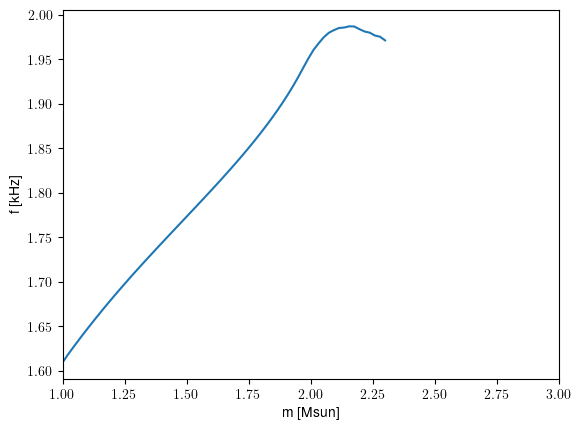

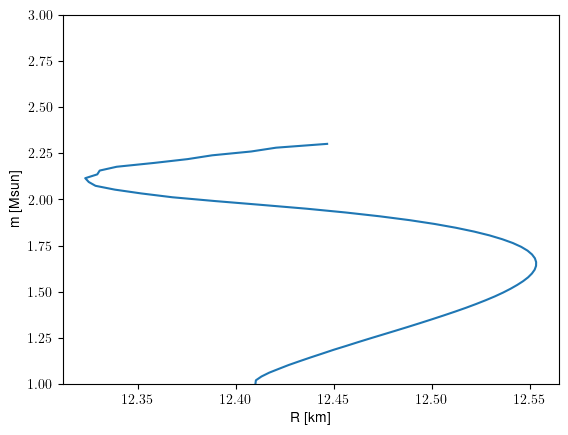

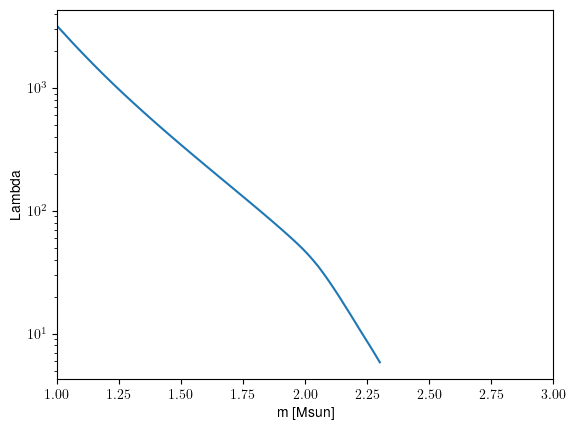

In [8]:
# plot mean f(m), R(m) and Lambda(m) relations

plt.plot(mApops,fApops)

plt.xlabel('m [Msun]')
plt.ylabel('f [kHz]')
plt.xlim(1.,3.)
plt.show()

plt.plot(RApops,mApops)

plt.ylabel('m [Msun]')
plt.xlabel('R [km]')
plt.ylim(1.,3.)
plt.show()

plt.plot(mApops,LApops)

plt.xlabel('m [Msun]')
plt.ylabel('Lambda')
plt.yscale('log')
plt.xlim(1.,3.)
plt.show()

In [9]:
# implement fmtidal phase model and define contact frequency

def Psi2(fgw,m1,m2,Lambda1,Lambda2,f1,f2): # m1, m2 in Msun, f1, f2 in Hz
    
    v = (G*(m1+m2)*Msun*np.pi*fgw)**(1./3.)
    
    X1 = m1/(m1+m2)
    X2 = m2/(m1+m2)
    eta = X1*X2

    Omega1 = G*m1*Msun*2.*np.pi*f1/c**3
    Omega2 = G*m2*Msun*2.*np.pi*f2/c**3
    
    quad1 = -(10*np.pi*np.sqrt(3.) - 27. - 30.*np.log(2.))*Lambda1*X1**6*(155.-147.*X1)*(v/c)**11/(96.*eta*Omega1**2)
    quad2 = -(10*np.pi*np.sqrt(3.) - 27. - 30.*np.log(2.))*Lambda2*X2**6*(155.-147.*X2)*(v/c)**11/(96.*eta*Omega2**2)
    
    return quad1+quad2

def Psi3(fgw,m1,m2,Lambdao1,Lambdao2,fo1,fo2):
    
    v = (G*(m1+m2)*Msun*np.pi*fgw)**(1./3.)
    
    X1 = m1/(m1+m2)
    X2 = m2/(m1+m2)
    eta = X1*X2
    
    Omegao1 = G*m1*Msun*2.*np.pi*fo1/c**3
    Omegao2 = G*m2*Msun*2.*np.pi*fo2/c**3
    
    oct1 = -1875.*(5.-6.*np.log(2))*LambdaOct1*X1**7*(v/c)**15/(16.*OmegaOct1**2)
    oct2 = -1875.*(5.-6.*np.log(2))*LambdaOct2*X2**7*(v/c)**15/(16.*OmegaOct1**2)
    
    return oct1+oct2

def fc(m1,m2,R1,R2): # in Hz
    
    return np.sqrt(G*(m1+m2)*Msun/(np.pi**2*(R1*1e5+R2*1e5)**3))

def Psi2c(m1,m2,R1,R2,Lambda1,Lambda2,f1,f2):
    
    return Psi2(fc(m1,m2,R1,R2),m1,m2,Lambda1,Lambda2,f1,f2)

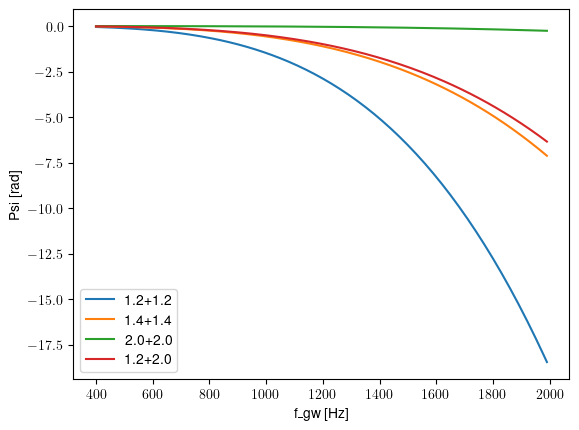

In [10]:
# plot dynamical tidal phase according to fmtidal model

fgrid = np.arange(400.,2000.,10.)

plt.plot(fgrid,Psi2(fgrid,1.2,1.2,1000.,1000.,1.4e3,1.4e3),label='1.2+1.2')
plt.plot(fgrid,Psi2(fgrid,1.4,1.4,390.,390.,1.6e3,1.6e3),label='1.4+1.4')
plt.plot(fgrid,Psi2(fgrid,2.0,2.0,10.,10.,1.8e3,1.8e3),label='2.0+2.0')
plt.plot(fgrid,Psi2(fgrid,1.2,2.0,1000.,10.,1.4e3,1.8e3),label='1.2+2.0')

plt.xlabel('f_gw [Hz]')
plt.ylabel('Psi [rad]')
plt.legend()
plt.show()

In [11]:
# calculate dynamical tidal phase at merger for simulated population, marginalizing over EOS

m1s, m2s, Psis = [], [], []
Psis_mn, Psis_lb, Psis_ub = [], [], []
Psis_matrix = np.full((len(mApops),len(mBpops)),np.inf)

for i,mA in tqdm(enumerate(mApops)):
    
    Psis_tmp = []
    
    for j,mB in enumerate(mBpops):
        
        if mB > mA: continue
        
        Psis_tmp2 = []
        
        for k,(fofm,Lofm,Rofm) in enumerate(zip(f_of_ms,L_of_ms,R_of_ms)):
            
            Psic = Psi2c(mA,mB,Rofm(mA),Rofm(mB),Lofm(mA),Lofm(mB),fofm(mA)*1e3,fofm(mB)*1e3)
            
            m1s += [mA]
            m2s += [mB]
            Psis += [Psic]
            Psis_tmp += [Psic]
            Psis_tmp2 += [Psic]
            
        Psis_matrix[i,j] = np.nanmean(Psis_tmp2)
            
    Psis_mn += [np.nanmean(Psis_tmp)]
    Psis_lb += [np.nanquantile(Psis_tmp,0.05)]
    Psis_ub += [np.nanquantile(Psis_tmp,0.95)]

64it [1:10:36, 66.20s/it]


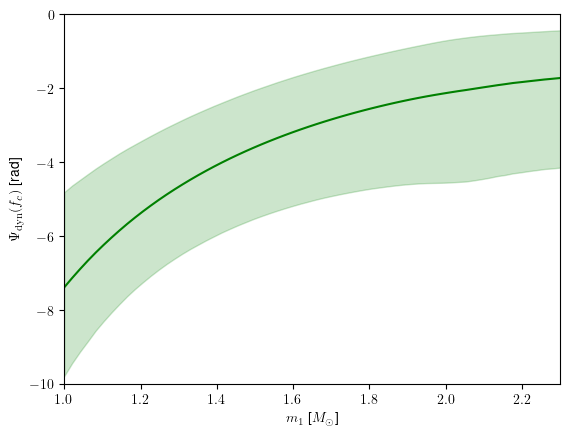

In [12]:
# save a few fixed-EOS traces and overplot with error envelope for dynamical tidal phase

'''
Psis_trace, m1s_trace = [], []

for mA in tqdm(mApops):
    
    for mB in mBpops:
        
        if mB > mA: continue
        
        for k,(fofm,Lofm,Rofm) in enumerate(zip(f_of_ms[0:3],L_of_ms[0:3],R_of_ms[0:3])):
            
            Psic = Psi2c(mA,mB,Rofm(mA),Rofm(mB),Lofm(mA),Lofm(mB),fofm(mA)*1e3,fofm(mB)*1e3)
            
            m1s_trace += [mA]
            Psis_trace += [Psic]

plt.scatter(m1s_trace,Psis_trace,c='k',s=2,alpha=0.1)
'''

plt.plot(mApops,Psis_mn,c='g')
plt.fill_between(mApops,Psis_lb,Psis_ub,color='g',alpha=0.2)

plt.xlabel(r'$m_1$ [$M_\odot$]')
plt.ylabel(r'$\Psi_{\rm dyn}(f_c)$ [rad]')
plt.xlim(1.,2.3)
plt.ylim(-10.,0.)
plt.savefig('psidyn.png')

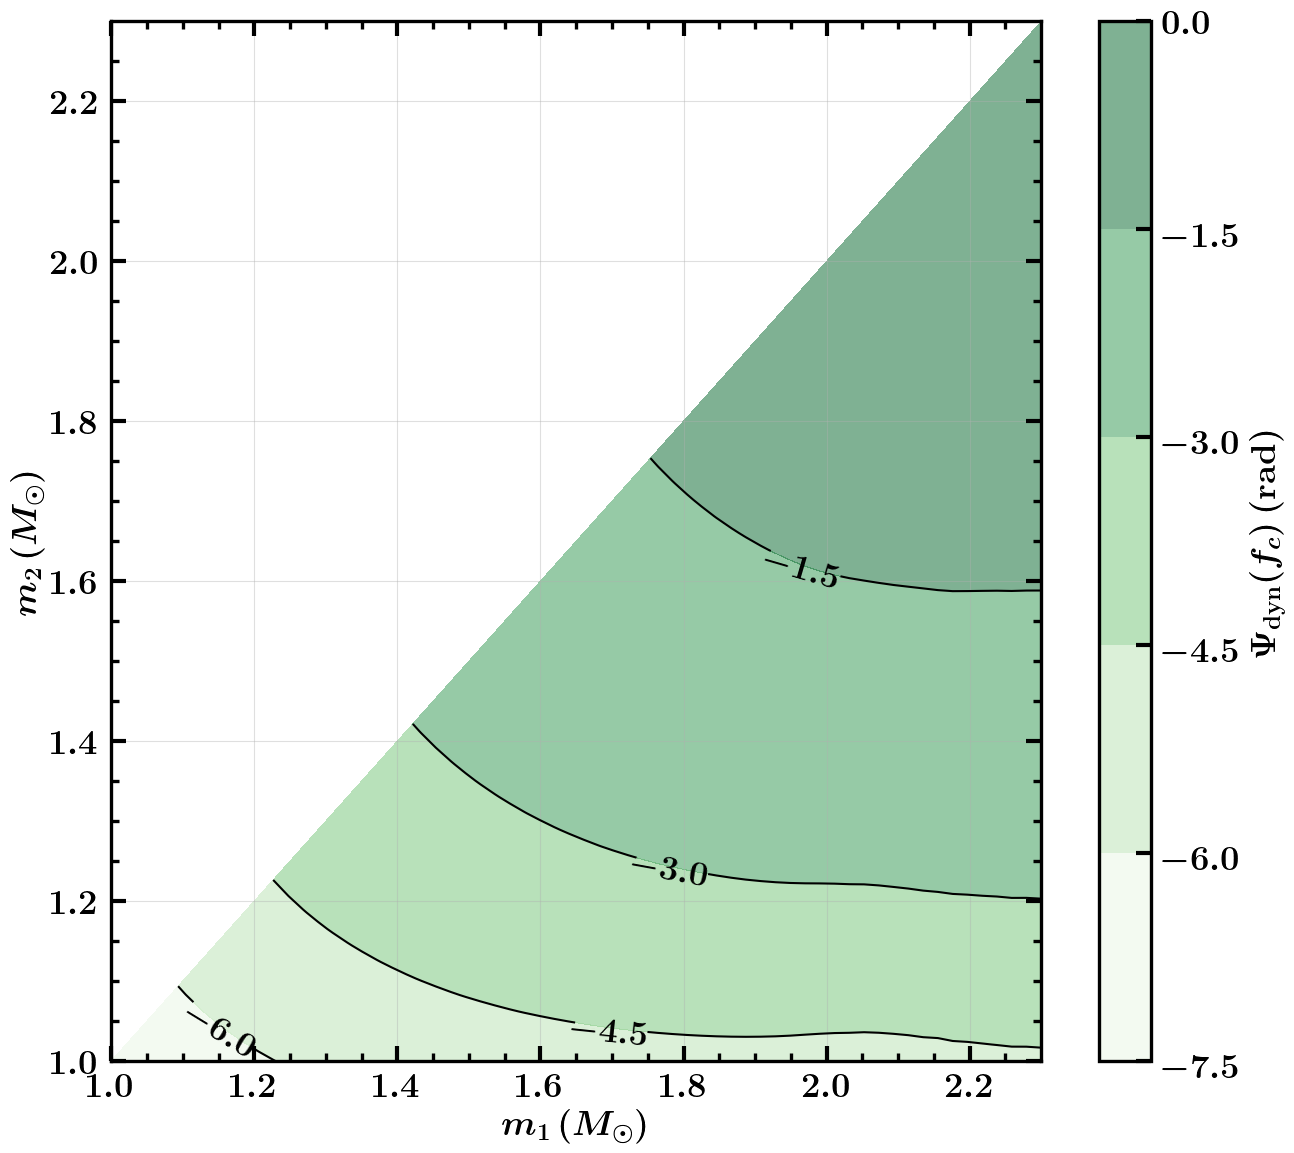

In [38]:
# make 2d contour plot version of the above

fig, ax = plt.subplots(1, figsize= (10*1.5,9*1.5))

cfs = ax.contourf(mApops,mBpops,np.nan_to_num(Psis_matrix.T,posinf=np.nan),alpha=0.5,levels=4,cmap='Greens')
cs = ax.contour(mApops,mBpops,np.nan_to_num(Psis_matrix.T,posinf=np.nan),levels=4,colors='k',linestyles='solid')

ax.clabel(cs, inline=True)
cbar = fig.colorbar(cfs,cmap='Greens',location='right',shrink=1,anchor=(0.,0.))

ax.set_xlabel(r'$m_1\,(M_\odot)$')
ax.set_ylabel(r'$m_2\,(M_\odot)$')
ax.set_xlim(1.,2.3)
ax.set_ylim(1.,2.3)
ax.grid(alpha = 0.4)
#cbar.ax.tick_params(labelsize=24)
cbar.set_label(label=r'$\Psi_{\rm dyn}(f_c)\,(\mathrm{rad})$')
plt.savefig('psidyn_2d.png')

In [36]:
# print average dynamical tidal phase and best estimate at optimal mass configuration, with errors

print(np.nanmean(Psis),np.nanquantile(Psis,0.05)-np.nanmean(Psis),np.nanquantile(Psis,0.95)-np.nanmean(Psis))

print(Psis_mn[0],Psis_lb[0]-Psis_mn[0],Psis_ub[0]-Psis_mn[0])

-2.7969720714148227 -2.846795880211401 2.035061945201742
-7.390163808105901 -2.401659526420919 2.57395876810961
